In [1]:
%reload_ext autoreload
%autoreload 2
import tensorflow as tf
import collections
import sys
import math
import numpy as np
sys.path.append('../../pytools')
import d2l
import os

d2l.gpu_mem_init()
tf.keras.config.disable_traceback_filtering()

2026-02-06 16:48:45.497672: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-06 16:48:45.560580: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-06 16:48:47.054497: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Memory growth enabled for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): True


In [2]:
#@save
class PositionWiseFFN(tf.keras.layers.Layer):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_hiddens, ffn_num_outputs, **kwargs):
        super().__init__(*kwargs)
        self.dense1 = tf.keras.layers.Dense(ffn_num_hiddens)
        self.relu = tf.keras.layers.ReLU()
        self.dense2 = tf.keras.layers.Dense(ffn_num_outputs)

    def call(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [3]:
ffn = PositionWiseFFN(4, 8)
res = ffn(tf.ones((2, 3, 4)))
res.shape

I0000 00:00:1770367728.229402 3401145 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8174 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:08.0, compute capability: 7.5


TensorShape([2, 3, 8])

In [4]:
ln = tf.keras.layers.LayerNormalization()
bn = tf.keras.layers.BatchNormalization()
X = tf.constant([[1, 2], [2, 3]], dtype=tf.float32)
print('layer norm:', ln(X), '\nbatch norm:', bn(X, training=True))

layer norm: tf.Tensor(
[[-0.998006    0.9980061 ]
 [-0.9980061   0.99800587]], shape=(2, 2), dtype=float32) 
batch norm: tf.Tensor(
[[-0.998006   -0.9980061 ]
 [ 0.9980061   0.99800587]], shape=(2, 2), dtype=float32)


In [5]:
#@save
class AddNorm(tf.keras.layers.Layer):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super().__init__(**kwargs)
        self.dropout = tf.keras.layers.Dropout(dropout)
        self.ln = tf.keras.layers.LayerNormalization(normalized_shape)
        #print(f"nshape:{normalized_shape}")

    def call(self, X, Y, **kwargs):
        return self.ln(self.dropout(Y, **kwargs) + X)

In [6]:
add_norm = AddNorm([1, 2], 0.5)
x = tf.random.normal((2,3,4))
print(f"x:{x}")
mean = np.mean(x[0])
std = np.std(x[0])
print(f"m:{mean}, std:{std}")
add_norm(x, x, training=False)

x:[[[ 2.140553   -1.0183516  -0.23402022  0.52439636]
  [ 0.00798855 -2.2173953   0.04611805 -0.00617931]
  [ 0.67126876  0.82275385  1.0642483   1.4899709 ]]

 [[-0.43353182 -0.2869015  -0.10166499  1.1965916 ]
  [-0.15523644 -1.0718852  -1.4636456   0.78820497]
  [ 1.6239073  -0.8156688   0.2225158   0.144486  ]]]
m:0.27427926659584045, std:1.0971648693084717


<tf.Tensor: shape=(2, 3, 4), dtype=float32, numpy=
array([[[ 1.70082   , -1.1780331 , -0.4632364 ,  0.22794308],
        [-0.24268283, -2.270776  , -0.20793368, -0.25559464],
        [ 0.36179453,  0.4998498 ,  0.7199347 ,  1.107915  ]],

       [[-0.46627563, -0.2970968 , -0.08337498,  1.414525  ],
        [-0.14518455, -1.2027938 , -1.6547983 ,  0.9433375 ],
        [ 1.9075525 , -0.9071769 ,  0.2906577 ,  0.20062862]]],
      dtype=float32)>

In [7]:
#@save
class EncoderBlock(tf.keras.layers.Layer):
    """Transformer编码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens,
                                                num_heads, dropout, bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def call(self, X, valid_lens, **kwargs):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens, **kwargs), **kwargs)
        return self.addnorm2(Y, self.ffn(Y), **kwargs)

In [8]:
X = tf.ones((2, 100, 24))
valid_lens = tf.constant([3, 2])
norm_shape = [i for i in range(len(X.shape))][1:]
encoder_blk = EncoderBlock(24, 24, 24, 24, norm_shape, 48, 8, 0.5)
encoder_blk(X, valid_lens, training=False).shape

/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:1484: UserWarning: Layer 'multi_head_attention' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its children layers).
Exception encountered: ''got an unexpected keyword argument 'kwargs'''
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'multi_head_attention', however the layer does not have a `build()` method implemented and it looks like i

TensorShape([2, 100, 24])

In [9]:
#@save
class TransformerEncoder(d2l.Encoder):
    """Transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_hiddens, num_heads,
                 num_layers, dropout, bias=False, **kwargs):
        super().__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = tf.keras.layers.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = [EncoderBlock(
            key_size, query_size, value_size, num_hiddens, norm_shape,
            ffn_num_hiddens, num_heads, dropout, bias) for _ in range(
            num_layers)]

    def call(self, X, valid_lens, **kwargs):
        # 因为位置编码值在-1和1之间，
        # 因此嵌入值乘以嵌入维度的平方根进行缩放，
        # 然后再与位置编码相加。
        X = self.pos_encoding(self.embedding(X) * tf.math.sqrt(
            tf.cast(self.num_hiddens, dtype=tf.float32)), **kwargs)
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens, **kwargs)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

In [10]:
encoder = TransformerEncoder(200, 24, 24, 24, 24, [1, 2], 48, 8, 2, 0.5)
encoder(tf.ones((2, 100)), valid_lens, training=False).shape

/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:1484: UserWarning: Layer 'multi_head_attention_1' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its children layers).
Exception encountered: ''got an unexpected keyword argument 'kwargs'''
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'multi_head_attention_1', however the layer does not have a `build()` method implemented and it looks li

TensorShape([2, 100, 24])

In [11]:
class DecoderBlock(tf.keras.layers.Layer):
    """解码器中第i个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_hiddens, num_heads, dropout, i, **kwargs):
        super().__init__(**kwargs)
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = d2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    ## TODO 原代码def call() 会报错，改成__call()__不报错, 原因待查
    def __call__(self, X, state, **kwargs):
        
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 训练阶段，输出序列的所有词元都在同一时间处理，
        # 因此state[2][self.i]初始化为None。
        # 预测阶段，输出序列是通过词元一个接着一个解码的，
        # 因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表示
        
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = tf.concat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if kwargs['training']:
            batch_size, num_steps, _ = X.shape
           # dec_valid_lens的开头:(batch_size,num_steps),
            # 其中每一行是[1,2,...,num_steps]
            dec_valid_lens = tf.repeat(tf.reshape(tf.range(1, num_steps + 1),
                                                 shape=(-1, num_steps)), repeats=batch_size, axis=0)

        else:
            dec_valid_lens = None

        # 自注意力
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens, **kwargs)
        Y = self.addnorm1(X, X2, **kwargs)
        # 编码器－解码器注意力。
        # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens, **kwargs)
        Z = self.addnorm2(Y, Y2, **kwargs)
        return self.addnorm3(Z, self.ffn(Z), **kwargs), state
        

In [12]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [1, 2], 48, 8, 0.5, 0)
X = tf.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state, training=False)[0].shape

TensorShape([2, 100, 24])

In [13]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_hidens, num_heads, num_layers, dropout, **kwargs):
        super().__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = [DecoderBlock(key_size, query_size, value_size, num_hiddens, norm_shape,
                                  ffn_num_hiddens, num_heads, dropout, i) for i in range(num_layers)]
        self.dense = tf.keras.layers.Dense(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]
    ##TODO call-->__call()__
    def __call__(self, X, state, **kwargs):
        X = self.pos_encoding(self.embedding(X) * tf.math.sqrt(tf.cast(self.num_hiddens, dtype=tf.float32)), **kwargs)
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]  # 解码器中2个注意力层
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state, **kwargs)
            # 解码器自注意力权重
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # “编码器－解码器”自注意力权重
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

loss 0.026, 1666.1 tokens/sec on <tensorflow.python.eager.context._EagerDeviceContext object at 0x7fd3b0193000>


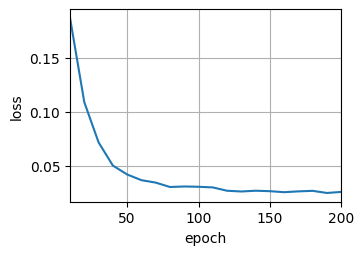

In [14]:
num_hiddens, num_layers, dropout, batch_size, num_steps =32, 1, 0.1, 128, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_hiddens, num_heads = 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [2]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens, norm_shape,
    ffn_num_hiddens, num_heads, num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens, norm_shape,
    ffn_num_hiddens, num_heads, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [15]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000
